In [9]:
import spacy, json, os, networkx as nx
from matplotlib import pyplot as plt
from pandas import read_csv as rcsv, DataFrame as df
from time import time as t
from datetime import datetime as dt

In [10]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
      
            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
        
            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [11]:
def get_relations(sent):
    doc = nlp(sent)
    
    # Matcher class object
    matcher = spacy.matcher.Matcher(nlp.vocab)
    relation=[]
    
    # define the pattern
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    matcher.add("matching_1", [pattern], on_match=None)

    matches = matcher(doc)
    if len(matches) != 0: 
        k = len(matches) - 1 
        span = doc[matches[k][1]:matches[k][2]]
        return(span.text)
    
    else: 
        return None

In [12]:
def json_(filepath : str, mode : str, dict_ : dict = None, *args, **kwargs):
    if mode == "w": # write
        if dict_ == None:
            raise ValueError("You must provide the data (in dictionary).")

        if not os.path.isdir(os.path.dirname(filepath)):
            os.makedirs(os.path.dirname(filepath))
        
        with open(filepath, mode) as f:
            json.dump(dict_, f)
        f.close()
        
    elif mode == "r": # read
        with open(filepath, mode) as f:
            x = json.load(f)
        f.close()
        return x

In [13]:
def get_graph_component(dataset, func, component, *args, **kwargs) -> list:
    if component not in ["edges", "nodes"]:
        raise ValueError("Available components are `nodes` and `edges` only.")
    
    root_path = "results/"
    ck_file = [f for f in os.listdir(root_path) if f.endswith("_{}.json".format(component))]
    
    if ck_file:
        # immediately return from the file
        return json_(filepath="{}{}".format(root_path, ck_file[0]), mode="r")["result"]
    
    else:
        start_time = t()
        C = [func(sn) for sn in dataset]
        
        # save to JSON file
        curr_ts = dt.now()
        response_dict = {
            "result" : json.loads(json.dumps(C)),
            "exc_time" : round(t()-start_time, 2),
            "created_at" : curr_ts.strftime("%Y-%m-%d %X")
        }
        
        json_(
            filepath="results/{}_{}.json".format(curr_ts.strftime("%Y%m%d"), component),
            mode="w", dict_=response_dict
        )
        
        return C

In [14]:
def plot_graph(dataset, select_edge, *args, **kwargs) -> None:
    G = nx.from_pandas_edgelist(dataset[dataset['edge'] == select_edge], "source", "target", \
                                edge_attr=True, create_using=nx.MultiDiGraph())

    plt.figure(figsize=(7, 7))
    
    pos = nx.spring_layout(G, k=.5) # k regulates the distance between nodes
    nx.draw(G, with_labels=True, node_color='xkcd:seafoam green', node_size=800, \
            font_size=8, edge_cmap=plt.cm.Blues, pos=pos)
    
    plt.show()

In [15]:
def analyze_graph(graph, centrality_top_k : int = 10, *args, **kwargs) -> dict:
    
    def sort_dict(dict_, top_k : int = centrality_top_k):
        tmp = dict(sorted(dict_.items(), key=lambda x: x[1], reverse=True))
        return {k : tmp[k] for idx, k in enumerate(tmp) if idx < top_k}
    
    return {
        "num_nodes" : graph.number_of_nodes(),
        "num_edges" : graph.number_of_edges(),
        "degree_centrality" : sort_dict(nx.degree_centrality(graph)),
        "betweenness_centrality" : sort_dict(nx.betweenness_centrality(graph)),
        "closeness_centrality" : sort_dict(nx.closeness_centrality(graph))
    }

### Create the Knowledge Graph

In [8]:
if __name__ == "__main__":
    # download first: python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')

    # load dataset
    wiki_dataset = rcsv("datasets/wiki_sentences_v2.csv")
    
    # get nodes (entities) and edges (relations)
    nodes = get_graph_component(wiki_dataset.sentence, get_entities, "nodes")
    nodes_source = [" ".join(i[0].split()) for i in nodes]
    nodes_target = [" ".join(i[1].split()) for i in nodes]
    
    edges = get_graph_component(wiki_dataset.sentence, get_relations, "edges")
    edges = [" ".join(e.split()) for e in edges]
    
    # combine in one DataFrame
    kg_df = df({"source" : nodes_source, "edge" : edges, "target" : nodes_target})
    kg_df = kg_df[(kg_df.source != '') & (kg_df.edge != '') & (kg_df.target != '')]
    kg_df.to_csv("results/knowledge_graph_wiki_v2.csv", index=False)
    
    # create a MultiDiGraph object from NetworkX
    myKG = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
    
    # analyze graph
    ag = analyze_graph(myKG)
    print("Number of nodes: {}".format(ag["num_nodes"]))
    print("Number of edges: {}".format(ag["num_edges"]))

Number of nodes: 4778
Number of edges: 4076


In [9]:
df({
    "degree" : ag["degree_centrality"].keys(),
    "degree_val" : ag["degree_centrality"].values(),
    "betweenness" : ag["betweenness_centrality"].keys(),
    "betweenness_value" : ag["betweenness_centrality"].values(),
    "closeness" : ag["closeness_centrality"].keys(),
    "closeness_val" : ag["closeness_centrality"].values()
})

,degree,degree_val,betweenness,betweenness_value,closeness,closeness_val
0,it,0.064057,film,0.000466,december,0.009320
1,film,0.054009,it,0.000385,positive reviews,0.008192
2,he,0.028679,this,0.000158,august,0.007751
3,they,0.014235,that,0.000111,april,0.007460
4,this,0.013188,music,0.000071,november,0.007284
5,i,0.012979,films,0.000065,mixed reviews,0.007197
6,she,0.008373,soundtrack,0.000055,may,0.006989
7,films,0.007117,sequel,0.000051,film,0.006870
8,that,0.006071,eilis,0.000042,box office,0.006689
9,we,0.005443,young men,0.000034,1963,0.006689


### Plot a subset of KGs (based on select edges)

In [10]:
kg_df.groupby("edge").edge.count().sort_values(ascending=False).head(20)

edge
is             359
was            292
released on     90
include         70
are             69
were            65
released        41
's              38
composed by     34
have            31
became          30
has             30
become          28
released in     27
included        23
had             21
produced        21
been            20
called          19
made            18
Name: edge, dtype: int64

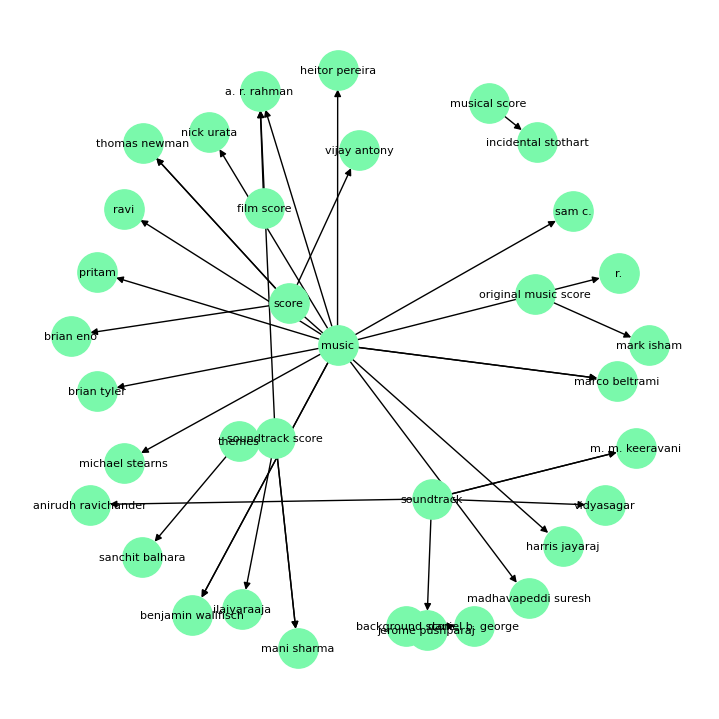

In [11]:
plot_graph(kg_df, "composed by")

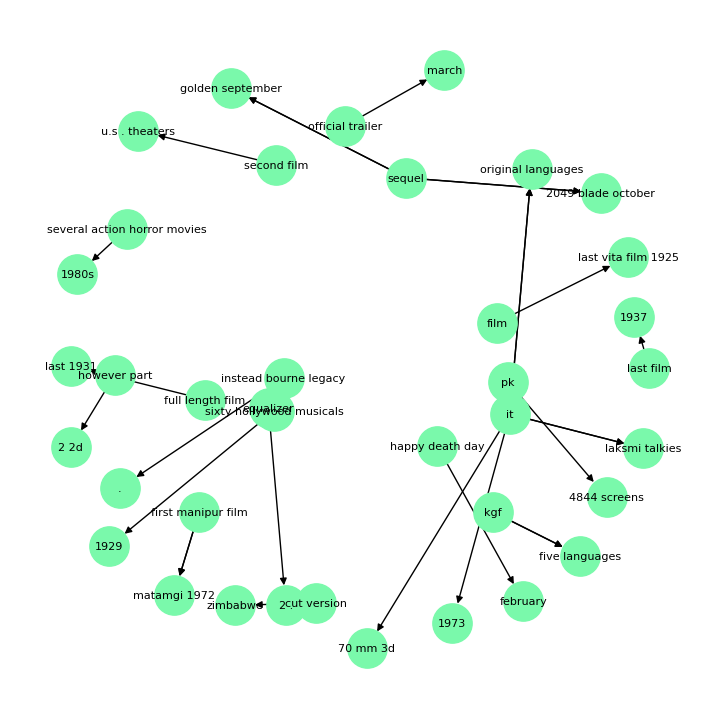

In [12]:
plot_graph(kg_df, "released in")

In [22]:
x = rcsv("results/knowledge_graph_wiki_v2.csv")

In [28]:
x[x.source=="movie"]

,source,edge,target
1407,movie,credited as,social drama feature film
1469,movie,credited as,social drama feature film
1901,movie,released on,april
1968,movie,was,political commentary
2053,movie,heals,breach
2054,movie,depends upon,timing
2231,movie,won,film institute award
2258,movie,won,film institute award
2918,movie,was,vivek oberoi
2944,movie,shot,entirely london


In [29]:
x[x.source=="music"]

,source,edge,target
287,music,limited to,singing
309,music,composed by,benjamin wallfisch
317,music,composed by,benjamin wallfisch
1110,music,composed by,sam c.
1227,music,composed by,brian tyler
2046,music,composed by,ravi
2406,music,composed by,michael stearns
2556,music,composed by,madhavapeddi suresh
2631,music,composed by,heitor pereira
3089,music,composed by,marco beltrami


In [27]:
x[x.source=="soundtrack"]

,source,edge,target
23,soundtrack,released,digitally june
795,soundtrack,composed by,vidyasagar
1363,soundtrack,composed by,jerome pushparaj
2035,soundtrack,composed by,anirudh ravichander
2134,soundtrack,contains,typically instrumentation
2140,soundtrack,contains,typically instrumentation
2211,soundtrack,released on,november
2865,soundtrack,added to,united states national recording registry
3381,soundtrack,scored by,veteran composer ilaiyaraaja
3614,soundtrack,marketed by,aditya music


### Generated by Google's Instruction-tuned Gemma 2B

In [6]:
sample_words = [
    "movie credited as social drama feature film",
    "movie released on april",
    "movie shot on paper film",
    "movie won film institute award",
    "music composed by benjamin wallfisch",
    "music released by aditya music company",
    "music received positive reviews",
    "soundtrack released digitally june",
    "soundtrack composed by anirudh ravichander",
    "soundtrack added to united states national recording registry"
]

In [7]:
generated_qs = [
    "Which movie was credited as a social drama feature film?",
    "What movie was released on April?",
    "What was the purpose of filming a movie scene on paper film?",
    "What was the movie that won the Film Institute Award?",
    "Which musical composition by Benjamin Wallfisch was released in 2004?",
    "Which music released by Aditya Music Company was the most popular?",
    "How did the music received positive reviews?",
    "What was the soundtrack released digitally June?",
    "What is the name of the soundtracks composed by Anirudh Ravichander?"
    "Which song was added to the Soundtrack of the United States National Recording Registry?"
]

In [8]:
{w : q for w, q in zip(sample_words, generated_qs)}

{'movie credited as social drama feature film': 'Which movie was credited as a social drama feature film?',
 'movie released on april': 'What movie was released on April?',
 'movie shot on paper film': 'What was the purpose of filming a movie scene on paper film?',
 'movie won film institute award': 'What was the movie that won the Film Institute Award?',
 'music composed by benjamin wallfisch': 'Which musical composition by Benjamin Wallfisch was released in 2004?',
 'music released by aditya music company': 'Which music released by Aditya Music Company was the most popular?',
 'music received positive reviews': 'How did the music received positive reviews?',
 'soundtrack released digitally june': 'What was the soundtrack released digitally June?',
 'soundtrack composed by anirudh ravichander': 'What is the name of the soundtracks composed by Anirudh Ravichander?Which song was added to the Soundtrack of the United States National Recording Registry?'}